## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import json
import math
import os
import keras
from math import ceil
import cv2
import matplotlib
from keras.optimizers import SGD
from sklearn.metrics import classification_report
import pickle
from keras.models import Model
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
from keras.activations import softmax, relu
from keras.optimizers import Adam, rmsprop, RMSprop   ,SGD
from keras.layers import BatchNormalization
from tensorflow import set_random_seed
from keras.applications import ResNet50
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, Dense, Dropout


%matplotlib inline

Using TensorFlow backend.


> ## Setting the parameter values.

In [2]:
SEED=12347 # Seeds
np.random.seed(SEED) 
set_random_seed(SEED)
CHANNEL_SIZE = 3 #Size of channel
NUM_EPOCHS = 50 #No of epochs for training
BATCH_SIZE = 16 # Batach size for training images.
IMG_DIM = 300 # Image size
NUM_CLASSES =5 # No of classes  

CLASSS={0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"} # Defination of each class of images.

## Loading Train and Test Data

In [3]:
df_train = pd.read_csv("/kaggle/input/aptos2019-blindness-detection/train.csv")
df_post = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')


### Displaying data records of training and testing data.

In [4]:
print(df_train.shape)
print(df_test.shape)
df_train.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


## Data Visualization.

### Visualizing training data in histogram and pie-chart.

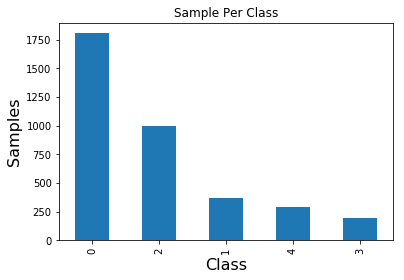

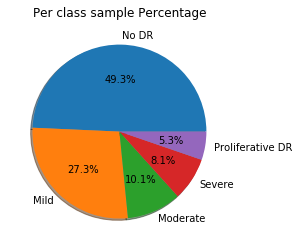

In [5]:
chat_data = df_train.diagnosis.value_counts()
chat_data.plot(kind='bar');
plt.title('Sample Per Class');
#fig.suptitle('test title', fontsize=20)
plt.xlabel('Class', fontsize=16)
plt.ylabel('Samples', fontsize=16)
plt.show()
plt.pie(chat_data, autopct='%1.1f%%', shadow=True, labels=["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"])
plt.title('Per class sample Percentage');
plt.show()

### No of data in each class.

In [6]:
print(df_train['diagnosis'].value_counts())

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64


### Display some random images from Data Set with class categories.

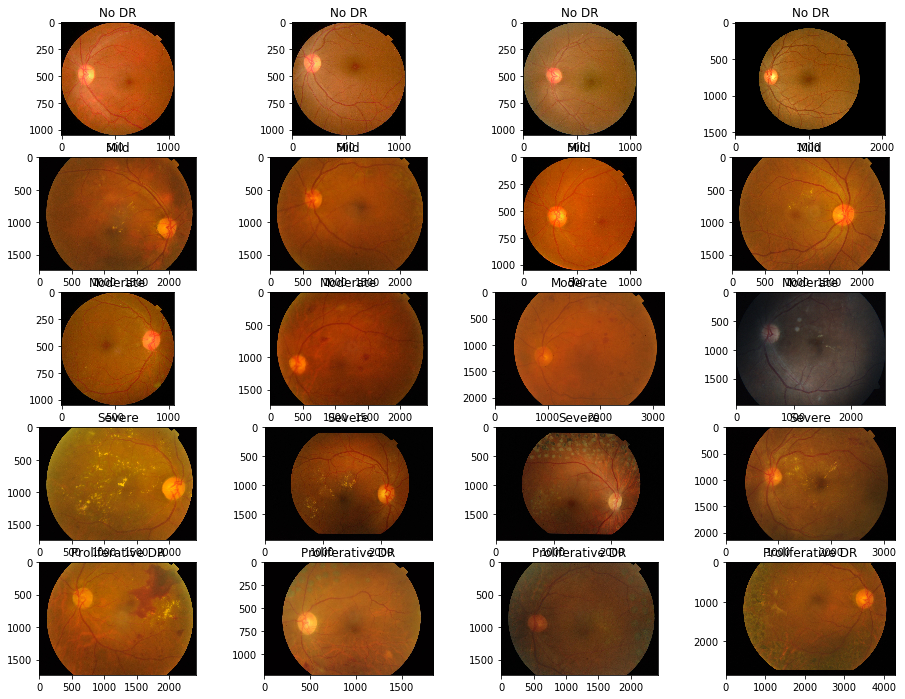

In [7]:

figure=plt.figure(figsize=(20,12))
for target_class in (df_train['diagnosis'].unique()):
#     print(CLASSS[target_class],target_class)
    for i, (idx, row ) in enumerate(df_train.loc[df_train.diagnosis==target_class].sample(4, random_state=SEED).iterrows()):
        ax= figure.add_subplot(5,5, target_class*5+i+1)
        imagefile=f"/kaggle/input/aptos2019-blindness-detection/train_images/{row['id_code']}.png" 
        img=cv2.imread(imagefile)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        ax.set_title(CLASSS[target_class])

In [8]:
# Concanating image extension with the data.
df_train.id_code=df_train.id_code.apply(lambda x: x+".png")
df_test.id_code=df_test.id_code.apply(lambda x: x+".png")
df_train['diagnosis'] = df_train['diagnosis'].astype('str')
df_train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


### Data Augumentation

In [9]:
# defining ImageDataGenrator for Data Augumentation.
train_datagen = ImageDataGenerator(
    rescale=1./255, # rescaling factor.
    validation_split=0.15, # Fraction of images reserved for validation
	rotation_range=30, # Degree range for random rotations.
	zoom_range=0.15, # Range for random zoom.
	width_shift_range=0.2, # width shift ranage 
	height_shift_range=0.2, # Height Shift Range
	shear_range=0.15, # Shear Intensity
	horizontal_flip=True, # Randomly flip inputs horizontally.
	fill_mode="nearest"
)

In [10]:
# Generating images after with image agumentation for training and validation.
train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory="../input/aptos2019-blindness-detection/train_images/",
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='training',
                                                    shaffle=True,
                                                    seed=SEED,
                                                    )
valid_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory="../input/aptos2019-blindness-detection/train_images/",
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='validation',
                                                    shaffle=True,
                                                    seed=SEED
                                                    )

Found 3113 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.


## Model Architecture Design

In [11]:
# Stops training once the model performance stops improving on a hold out validation dataset.
eraly_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto',
                              verbose=1)
# Save the model after every epoch.
checkpoint = ModelCheckpoint('../working/resnet50_.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
# Callback that streams epoch results to a csv file.
csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)
callbacks_list = [checkpoint, csv_logger, reduce_lr, eraly_stop] 

In [12]:
# Defining Traning and validating batch size for image processing.
NUB_TRAIN_STEPS = train_generator.n // train_generator.batch_size
NUB_VALID_STEPS = valid_generator.n // valid_generator.batch_size

NUB_TRAIN_STEPS, NUB_VALID_STEPS

(194, 34)

In [13]:

def create_resnet(img_dim, CHANNEL, n_class):
    input_tensor = Input(shape=(img_dim, img_dim, CHANNEL))

    base_model = ResNet50(weights=None, include_top=False, input_tensor=input_tensor)
    base_model.load_weights('/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    output_layer = Dense(n_class, activation='softmax', name="Output_Layer")(x)
    model_resnet = Model(input_tensor, output_layer)

    return model_resnet

model_resnet = create_resnet(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)

In [14]:
# Adjusting all the layers of the model to train on the dataset.
for layers in model_resnet.layers:
    layers.trainable = True

In [15]:
lr = 1e-4
optimizer =SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True) # defining Optimizer
model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy, metrics=['accuracy']) #Compiling the model before training.


### Model Training and Evaluation

In [16]:
history = model_resnet.fit_generator(generator=train_generator,
                                     steps_per_epoch=NUB_TRAIN_STEPS,
                                     validation_data=valid_generator,
                                     validation_steps=NUB_VALID_STEPS,
                                     epochs=NUM_EPOCHS,
                                                                 shuffle=True,  
                                     callbacks=callbacks_list,
                                     verbose=1)

Epoch 1/50
194/194 [==============================] - 504s 3s/step - loss: 1.4690 - acc: 0.4646 - val_loss: 0.8608 - val_acc: 0.6967

Epoch 00001: val_loss improved from inf to 0.86077, saving model to ../working/resnet50_.h5
Epoch 2/50
194/194 [==============================] - 460s 2s/step - loss: 1.0028 - acc: 0.6564 - val_loss: 0.8381 - val_acc: 0.6886

Epoch 00002: val_loss improved from 0.86077 to 0.83814, saving model to ../working/resnet50_.h5
Epoch 3/50
194/194 [==============================] - 474s 2s/step - loss: 0.9013 - acc: 0.6891 - val_loss: 0.7172 - val_acc: 0.7355

Epoch 00003: val_loss improved from 0.83814 to 0.71722, saving model to ../working/resnet50_.h5
Epoch 4/50
194/194 [==============================] - 464s 2s/step - loss: 0.8297 - acc: 0.7074 - val_loss: 0.6747 - val_acc: 0.7636

Epoch 00004: val_loss improved from 0.71722 to 0.67475, saving model to ../working/resnet50_.h5
Epoch 5/50
194/194 [==============================] - 465s 2s/step - loss: 0.7875 - 

In [17]:
history.history.keys() # Access Model Training History

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

### Training visualization

**Accuracy Vs Epoch curve**

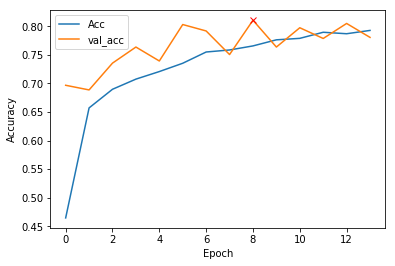

In [18]:
accu = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(accu, label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'val_acc'])
plt.plot(np.argmax(history.history["val_acc"]), np.max(history.history["val_acc"]), marker="x", color="r",
         label="best model")
plt.show()

**log loss Vs Epoch(Learning curve)**

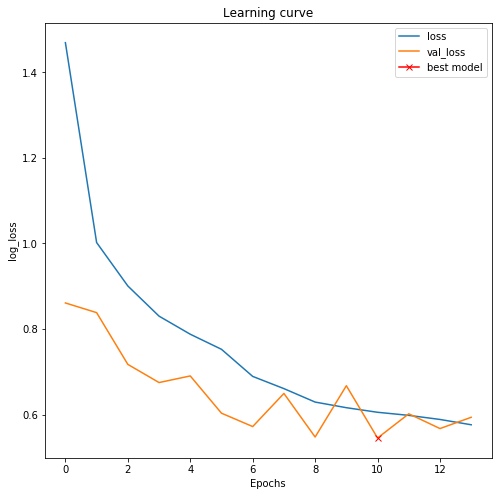

In [19]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r",
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

**Display the accuracy and loss obtain by the final model.**

In [20]:
(eval_loss, eval_accuracy) = tqdm(
    model_resnet.evaluate_generator(generator=valid_generator, steps=NUB_VALID_STEPS, pickle_safe=False))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

100%|██████████| 2/2 [00:00<00:00, 2774.93it/s]

[INFO] accuracy: 79.55%
[INFO] Loss: 0.5410119675057914


In [21]:
model_resnet.load_weights('../working/resnet50_.h5') # Load the best weight which perform well on the data.

### Testing Dataset

**Loading Test Dataset images for predicting label**

In [22]:

test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_dataframe(dataframe=df_test,
                                                directory = "../input/aptos2019-blindness-detection/test_images/",
                                                x_col="id_code",
                                                target_size=(IMG_DIM, IMG_DIM),
                                                batch_size=1,
                                                shuffle=False, 
                                                class_mode=None, 
                                                seed=SEED)

Found 1928 validated image filenames.


**Test Time Augmentation**

In [23]:
tta_steps = 10
preds_tta=[]
for i in tqdm(range(tta_steps)):
    test_generator.reset()
    preds = model_resnet.predict_generator(generator=test_generator,steps =ceil(df_test.shape[0]))
    #print('Before ', preds.shape)
    preds_tta.append(preds)
    #print(i,  len(preds_tta))

100%|██████████| 10/10 [13:41<00:00, 81.43s/it]


**Predicting the labels on the test dataset**

In [24]:
final_pred = np.mean(preds_tta, axis=0)
predicted_class_indices = np.argmax(final_pred, axis=1)
len(predicted_class_indices)

1928

**Saving the result in a dataframe with respect to the image ID**

In [25]:
results=pd.DataFrame({"id_code":test_generator.filenames, "diagnosis":predicted_class_indices})  
results.id_code=results.id_code.apply(lambda x: x[:-4])# results.head()
results.to_csv("submission.csv", index=False)

**Test Data Visualization**

Text(0, 0.5, 'Samples')

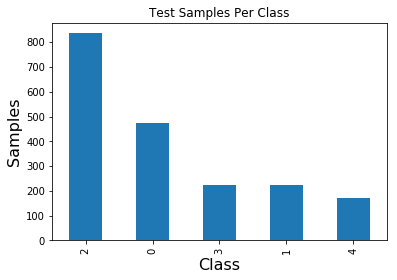

In [26]:
results['diagnosis'].value_counts().plot(kind='bar');
plt.title('Test Samples Per Class');
plt.xlabel('Class', fontsize=16)
plt.ylabel('Samples', fontsize=16)

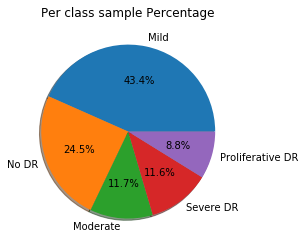

In [27]:
plt.pie(results.diagnosis.value_counts(), autopct='%1.1f%%', shadow=True, labels=["Mild","No DR","Moderate","Severe DR", "Proliferative DR"])
plt.title('Per class sample Percentage');
plt.show()

In [28]:
results['diagnosis'].value_counts()

2    836
0    473
3    225
1    224
4    170
Name: diagnosis, dtype: int64